# 深度学习 实验6 降维

降维（dimension reduction）的基本作用：
1. 减轻维数灾难（curse of dimensionality）
2. 数据去冗余、去噪音
3. 可视化

本次实验内容包含：
1. 对MNIST手写数字数据集进行降维，并可视化其特征
2. 使用KNN算法对降维后的MNIST手写数字数据集进行分类，探究维度降低对分类精确度以及时间开销的影响
3. 尝试另外两种降维算法：t-SNE和LDA

# 实验预先准备

首先加载一些必要的python库和可视化工具

In [2]:
import numpy as np
import pandas as pd 

In [3]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib

调用sklearn库，加载用于降维的PCA工具，以及后面用来比较的T-sne和LDA

In [72]:
# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

再从sklearn调用knn算法，用于比较降维前后的性能差异

In [93]:
from sklearn.neighbors import KNeighborsClassifier

KNN预测非常耗时，我们可以在最后看一下降维缩减掉的时间开销

In [92]:
import time

读取MNIST手写数字数据集

In [73]:
train = pd.read_csv('data/mnist_train.csv')
test = pd.read_csv('data/mnist_test.csv')

In [79]:
print(train.shape)
print(test.shape)

(60000, 785)
(10000, 785)


In [75]:
train.head(8)

label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   
5      2    0    0    0    0    0    0    0    0    0  ...      0      0   
6      1    0    0    0    0    0    0    0    0    0  ...      0      0   
7      3    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  
5      0      0      0      0      0      0      0      0  
6      0      0      0      0      0      0      0      0  
7      0      0      0      0      0      0      0      0  

[8 rows x 785 columns]

In [78]:
train_label = train['label']
test_label = test['label']
# Drop the label feature
train_vis = train.drop("label",axis=1)

看一下数据集中的数字

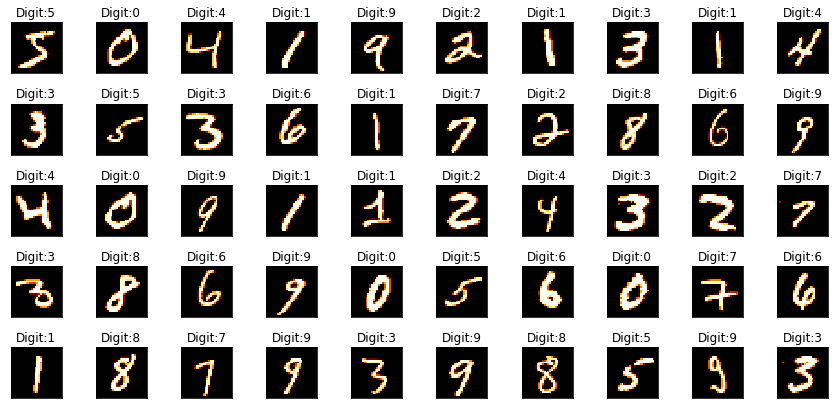

In [80]:
# plot some of the numbers
plt.figure(figsize=(12,8))
for digit_num in range(0,50):
    plt.subplot(7,10,digit_num+1)
    grid_data = train_vis.iloc[digit_num].values.reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
    each_title = 'Digit:'+str(train_label[digit_num])
    plt.title(each_title)
plt.tight_layout()

# 主成分分析

## 数据预处理

进行PCA之前需要先对我们的MNIST数据集进行标准化处理消除偏差

In [81]:
X = train.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0],
               reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp) 

## 特征值的可视化

我们调用sklearn中的主成分分析方法，从原始数据中提取一部分特征，随后将这部分特征进行可视化

往往前几个特征向量和特征值，就能保有这张图片的绝大部分信息，对MNIST这样比较干净的数据集而言更是

In [83]:
n_components = 25
pca = PCA(n_components=n_components).fit(train_vis.values)
eigenvalues = pca.components_.reshape(n_components, 28, 28)
eigenvalues = pca.components_

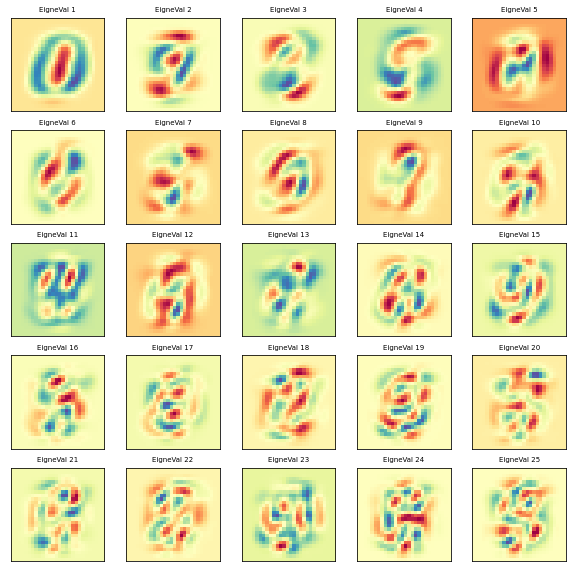

In [84]:
n_row = 5
n_col = 5 
# 可视化特征
plt.figure(figsize=(10,10))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap='Spectral') #cool GnBu
    title_text = 'EigneVal ' + str(i + 1)
    plt.title(title_text, size=7)
    plt.xticks(())
    plt.yticks(())
plt.show()

# 降维效果分析

## 使用KNN分类器进行分类

测试数据10,000个，我们先降到10维试试使用KNN分类器的分类效果

In [97]:
pca = PCA(n_components = 10)
pca.fit(train)
train_data_pca = pca.transform(train)
test_data_pca = pca.transform(test)
print("principal component:",n_components)
print ("Training Set data dimension after PCA:",train_data_pca.shape)
print ("Test Set data dimension after PCA:",test_data_pca.shape)

principal component: 25
Training Set data dimension after PCA: (60000, 10)
Test Set data dimension after PCA: (10000, 10)


In [95]:
starttime = time.time()
pca_knn = KNeighborsClassifier(n_neighbors=2)
pca_knn.fit(train_data_pca, train_label)
#计算测试得分
print(pca_knn.score(test_data_pca, test_label))
endtime = time.time()
print('Time Consumption:', round(endtime - starttime, 2),'secs')

0.9094
Time Consumption: 1.24 secs


降低到10维后在三个邻居的情况下获得了90%的精确度

然后对没有降维度的数据集进行测试，比较降低维度在预测精度上的损失

**说实话，不降维的情况下预测非常慢...毕竟knn是个惰性的分类器，只是把数据记住而已，开销了海量时间在计算距离上**

In [89]:
original_data_knn = KNeighborsClassifier(n_neighbors=2)
original_data_knn.fit(train, train_label)
original_data_knn.score(test, test_label)

0.9627

## 特征数量对预测结果的影响

In [114]:
def visualize_accuracy(data1):
    line1,=plt.plot(data1,'c',label='accuracy')
    plt.title('Visualize KNN Accuracy After PCA')
    plt.legend(handles=[line1],labels=['accuracy'], loc='best')
    plt.grid(linestyle='-.')
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel('Principal Components')
    plt.ylabel('Accuracy')
    plt.show()

In [115]:
def visualize_time_consumption(data1):
    line1,=plt.plot(data1,'coral',label='Time Consumption')
    plt.title('Visualize Time Consumption After PCA')
    plt.legend(handles=[line1],labels=['Time Consumption'], loc='best')
    plt.grid(linestyle='-.')
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel('Principal Components')
    plt.ylabel('Time Consumption')
    plt.show()

In [104]:
accuracy_list = []
time_consumption = []
for comp in range (1,50):
    pca = PCA(n_components = comp)
    pca.fit(train)
    train_data_pca = pca.transform(train)
    test_data_pca = pca.transform(test)
    starttime = time.time()
    pca_knn = KNeighborsClassifier(n_neighbors=2)
    pca_knn.fit(train_data_pca, train_label)
    acc=pca_knn.score(test_data_pca, test_label)
    endtime = time.time()
    time_consunmption=round(endtime - starttime, 2)
    print("component:",comp,"accuracy:", acc,'Time Consumption:',time_consunmption,'secs')
    accuracy_list.append(acc)
    time_consumption.append(time_consunmption)

component: 1 accuracy: 0.2654 Time Consumption: 0.29 secs
component: 2 accuracy: 0.3961 Time Consumption: 0.25 secs
component: 3 accuracy: 0.4545 Time Consumption: 0.25 secs
component: 4 accuracy: 0.5815 Time Consumption: 0.29 secs
component: 5 accuracy: 0.6898 Time Consumption: 0.33 secs
component: 6 accuracy: 0.7845 Time Consumption: 0.41 secs
component: 7 accuracy: 0.8325 Time Consumption: 0.55 secs
component: 8 accuracy: 0.867 Time Consumption: 0.66 secs
component: 9 accuracy: 0.8896 Time Consumption: 0.89 secs
component: 10 accuracy: 0.9096 Time Consumption: 1.1 secs
component: 11 accuracy: 0.9203 Time Consumption: 1.36 secs
component: 12 accuracy: 0.9309 Time Consumption: 1.65 secs
component: 13 accuracy: 0.9404 Time Consumption: 2.07 secs
component: 14 accuracy: 0.9462 Time Consumption: 2.59 secs
component: 15 accuracy: 0.9486 Time Consumption: 2.86 secs
component: 16 accuracy: 0.9574 Time Consumption: 3.52 secs
component: 17 accuracy: 0.9575 Time Consumption: 4.22 secs
componen

观察曲线可以发现KNN分类器的精确度随着特征个数上升而上升，直到20个特征时开始逐渐平缓，最后上下出现微小波动

可见前二十个特征值就能包含绝大多数的图片信息，而且降维后的数据在测试集性能上还出现略微优于原始数据的情况，我个人人认为这是PCA把影响低的像素点去除以后把影响大的特征的差异相对放大所导致的，而KNN就是依靠这种差异来进行预测的。

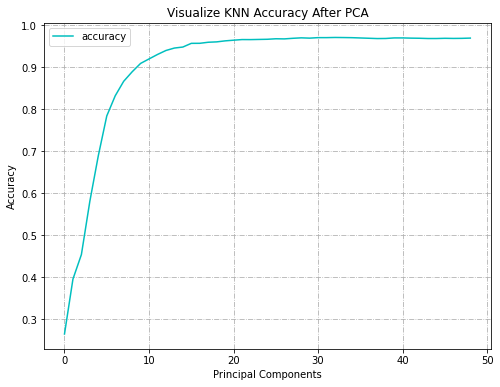

In [116]:
visualize_accuracy(accuracy_list)

随后可以看到，主成分降维发可以显著减少KNN算法的时间的开销，其预测所花费的时间远远小于对原始数据的预测所耗费的时间

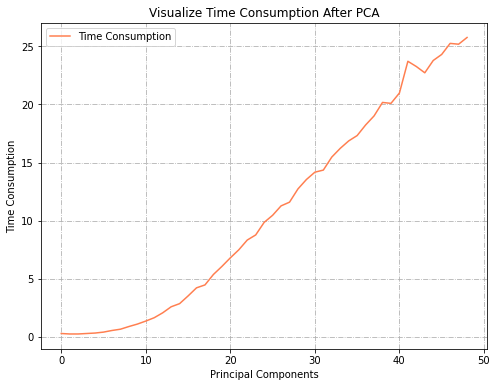

In [113]:
visualize_time_consumption(time_consumption)

# 降维算法比较

PCA是一种经典的降维算法，但除了PCA外还有两种可用的降维方式，在此处做一下取两个主成分的到的分布可视化

## PCA结果可视化

In [120]:
X= train[:5000].values # 从训练集把数据读进来
# PCA visualization
X_std = StandardScaler().fit_transform(X)
k = 5
pca = PCA(n_components=k) # k 为主成分个数，自定
pca.fit(X_std)
X_5d = pca.transform(X_std)
Target = target[:5000]

(因为离线模式用Plotly的话生成的交互图片会消失，所以我直接在这里加载了静态图片，可视化部分比较冗杂的代码在visualize.py中)

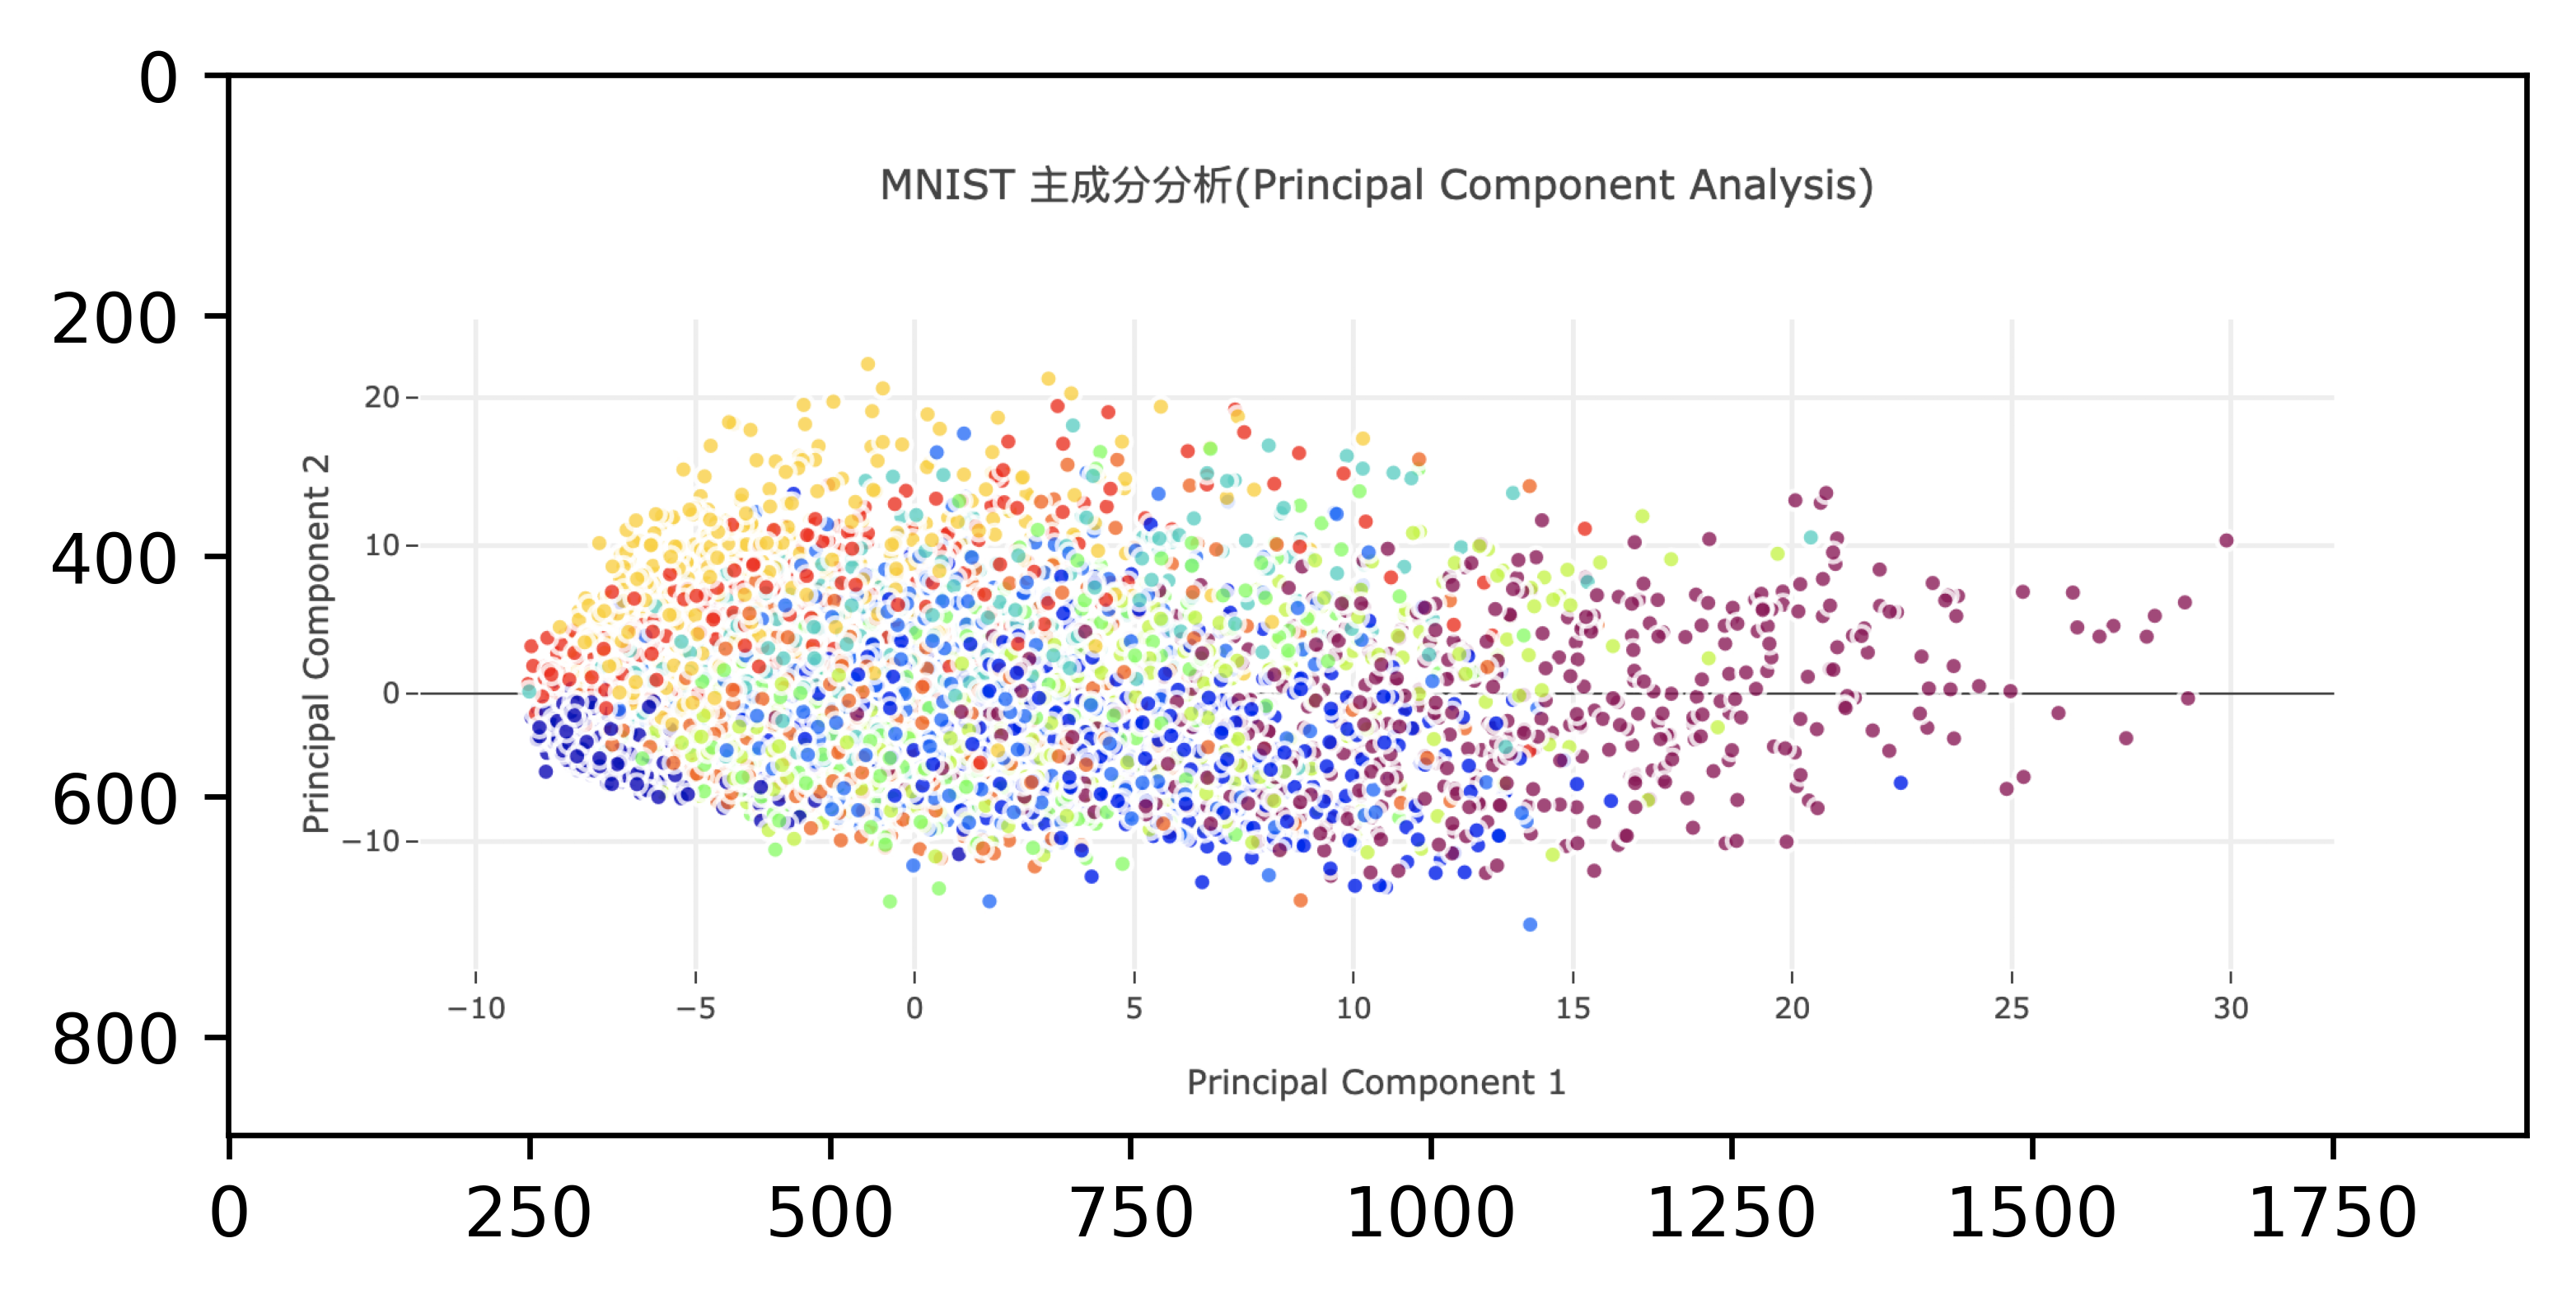

In [11]:
plt.rcParams['savefig.dpi'] = 600 #图片像素
plt.rcParams['figure.dpi'] = 600 #分辨率
pca_plot = plt.imread("./Pca-visualization.png")
plt.imshow(pca_plot)

## LDA以及结果可视化

LDA(Linear Discriminant Analysis)与PCA保持数据信息的同时减少维度不同，LDA是为了使得降维后的数据点尽可能地容易被区分。

In [121]:
lda = LDA(n_components=k)
X_LDA_2D = lda.fit_transform(X_std, Target.values )

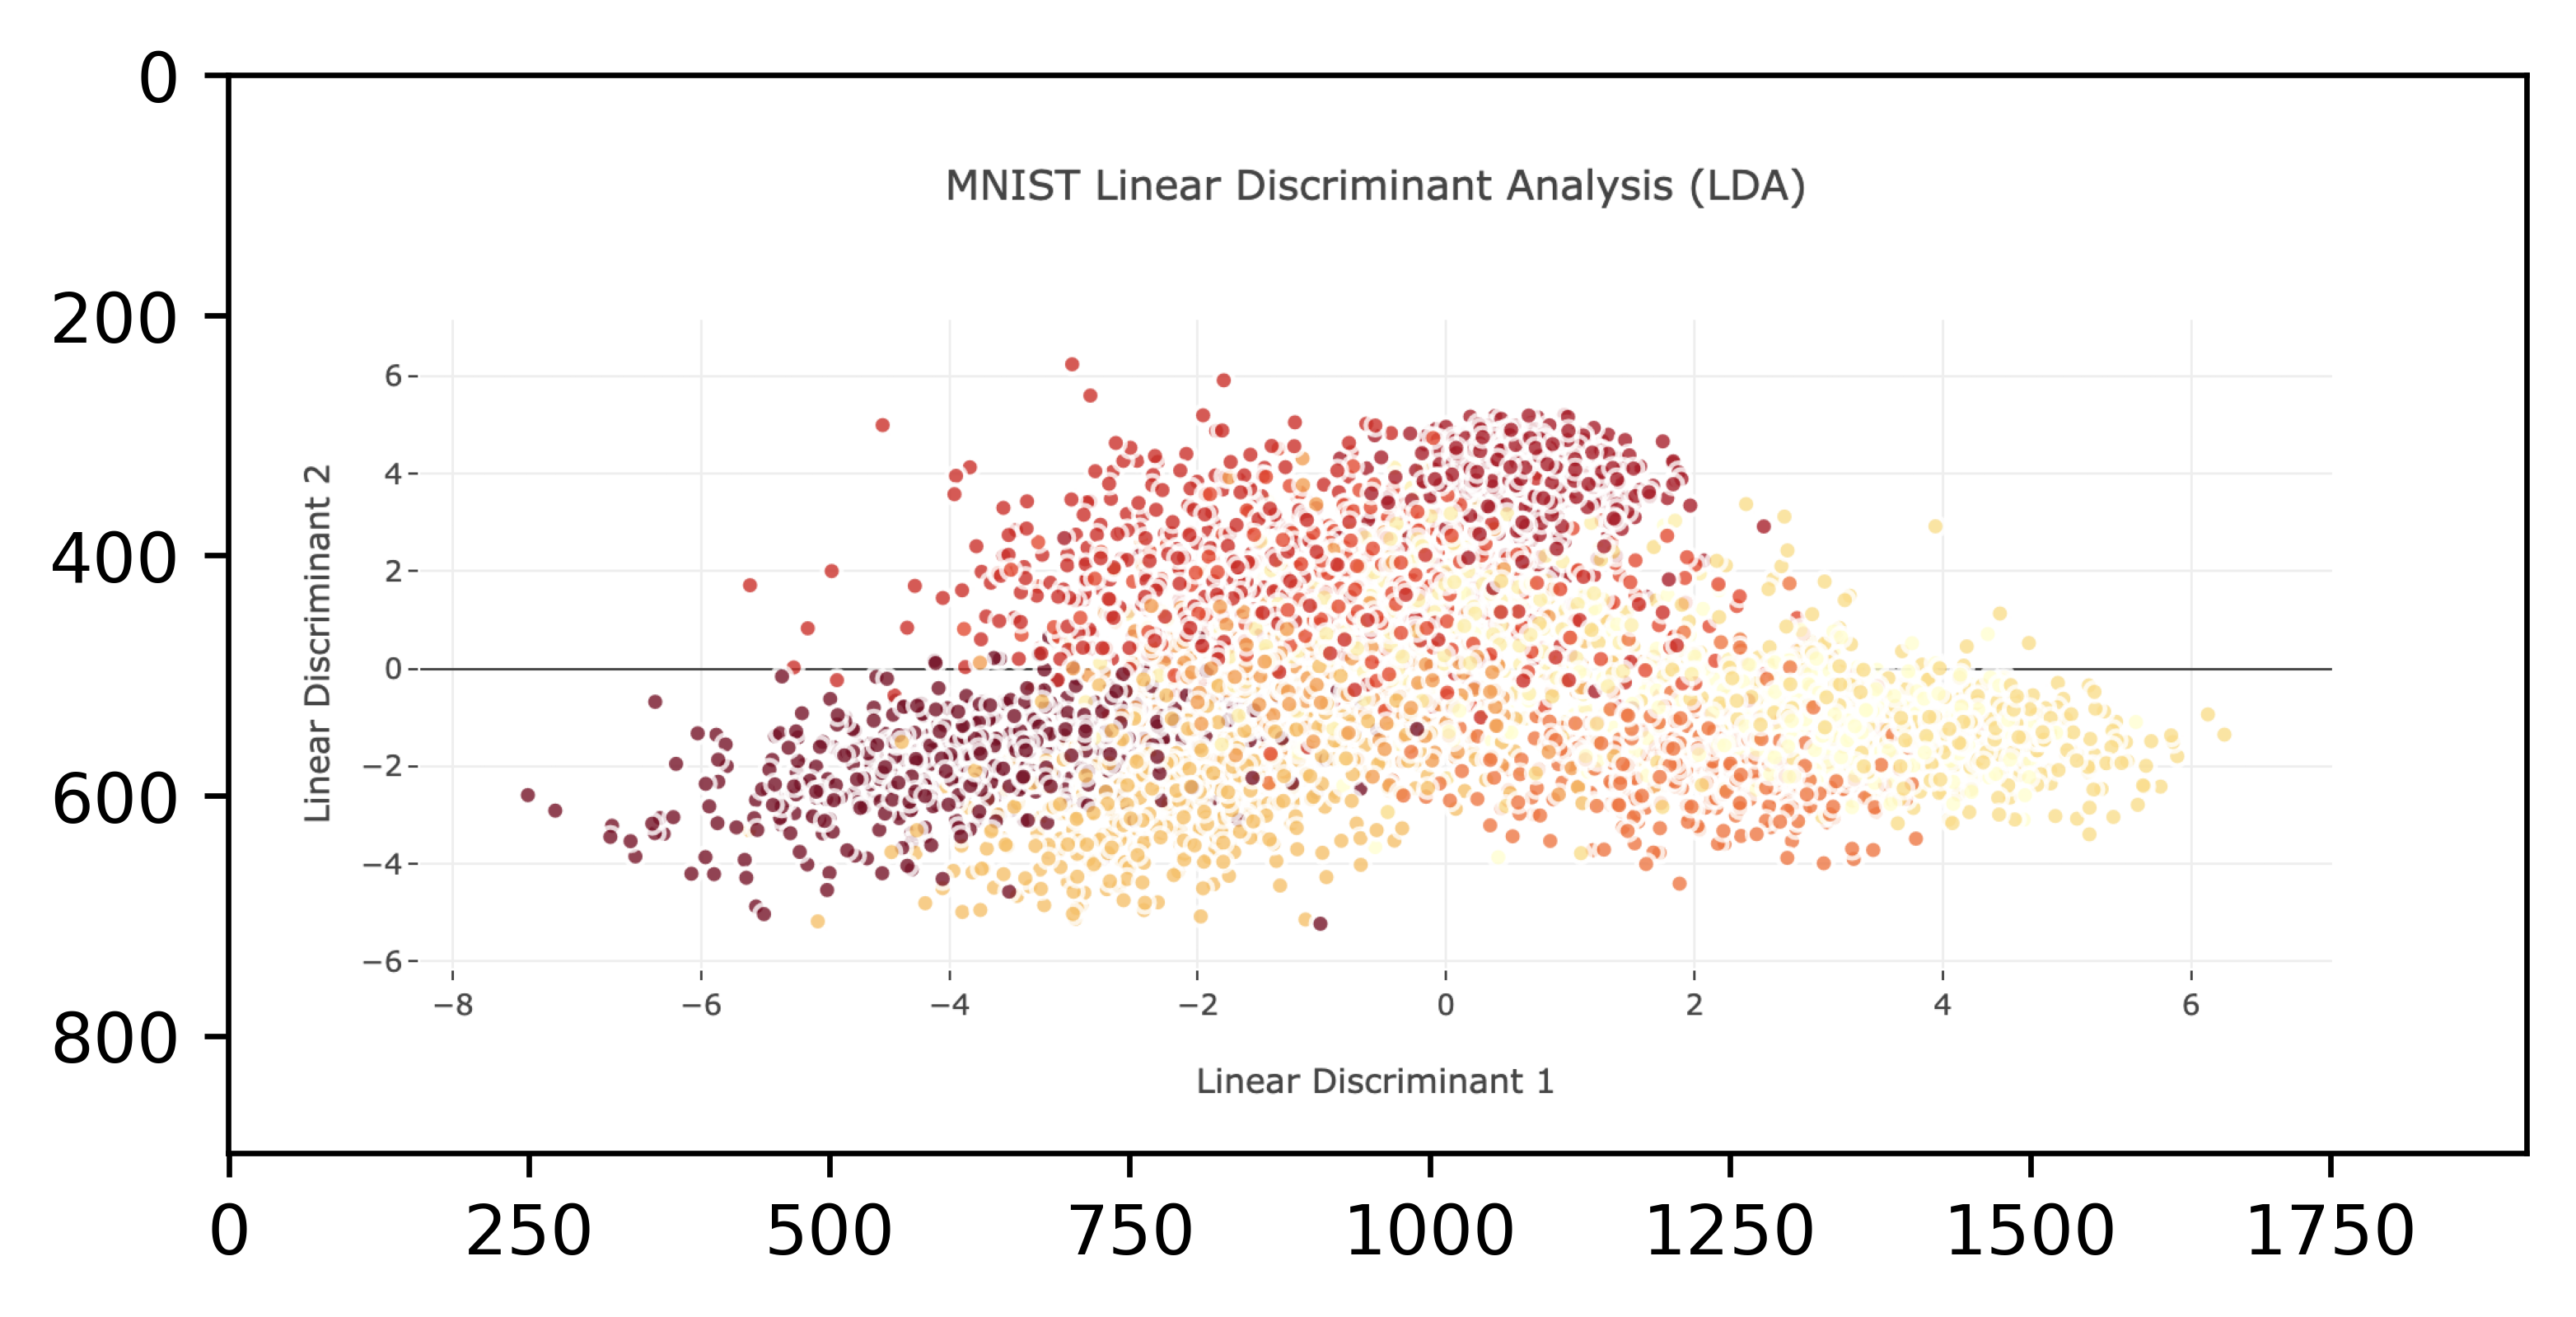

In [13]:
plt.rcParams['savefig.dpi'] = 600 #图片像素
plt.rcParams['figure.dpi'] = 600 #分辨率
pca_plot = plt.imread("./Lda-visualization.png")
plt.imshow(pca_plot)

## t-SNE以及结果可视化

t-SNE(t-Distributed Stochastic Neighbor Embedding)，用于在二维或三维的低维空间中表示高维数据集。与其他降维算法如PCA等相比，t-SNE创建了一个缩小的特征空间，相似的样本由附近的点建模，不相似的样本由高概率的远点建模。当我们要对高维数据进行分类，又不清楚这个数据集有没有很好的可分性（即同类之间间隔小，异类之间间隔大），可以通过t-SNE投影到2维或者3维的空间中观察一下，所以说t-SNE很大程度上为可视化服务

In [122]:
n = 2
tsne = TSNE(n_components=n)
tsne_results = tsne.fit_transform(X_std) 

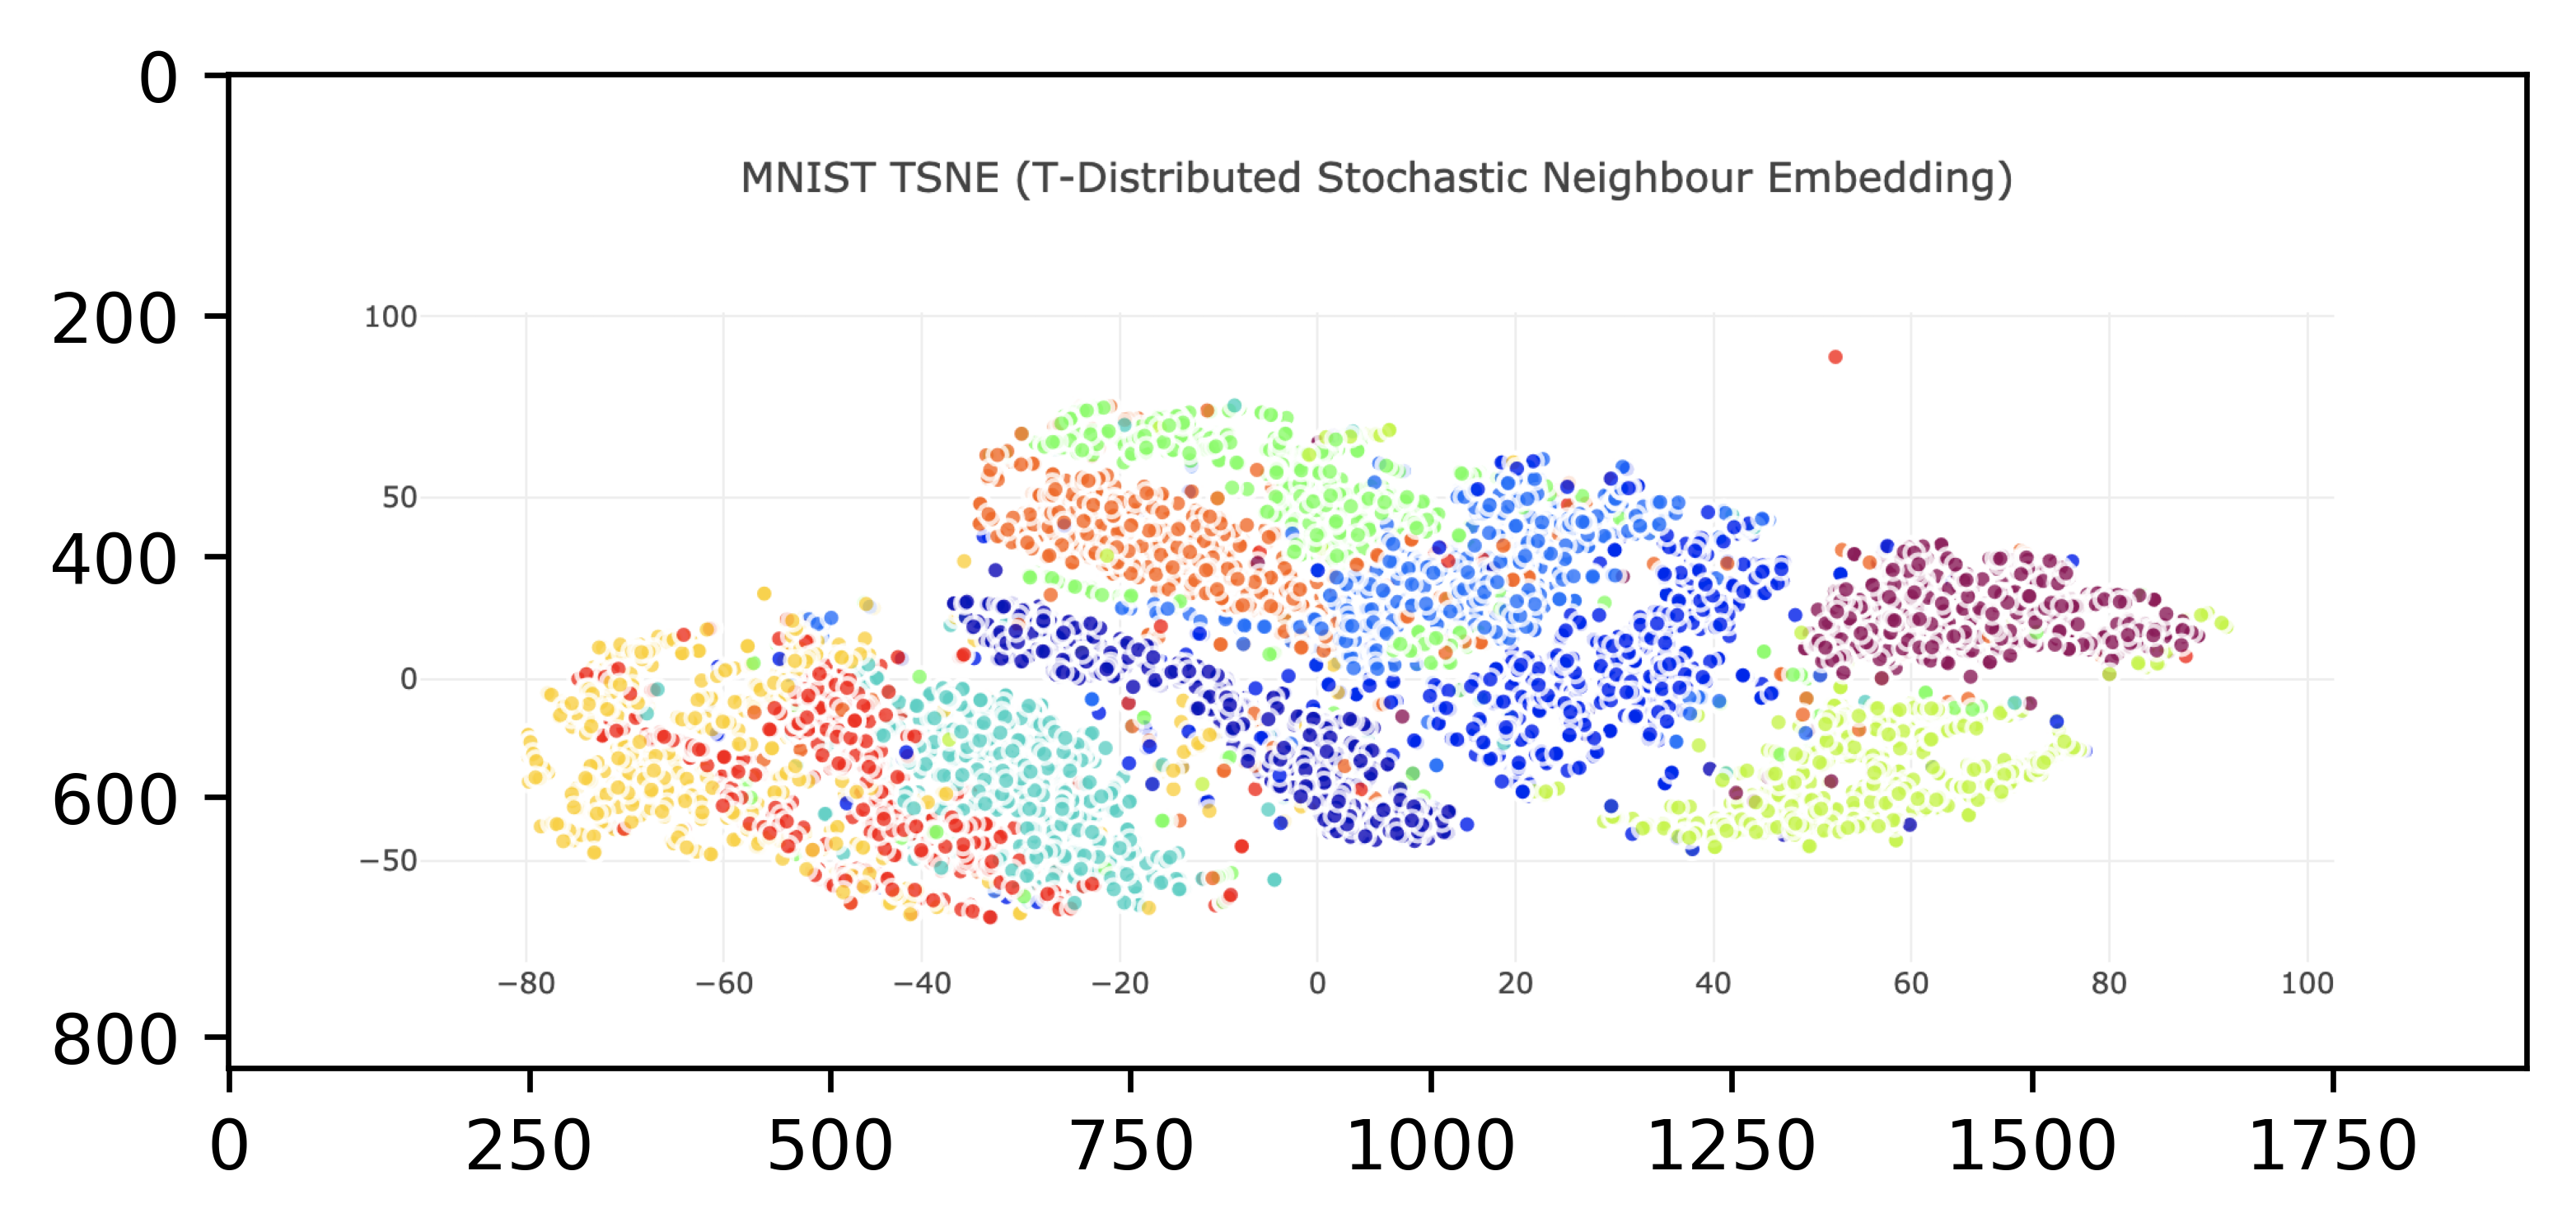

In [14]:
plt.rcParams['savefig.dpi'] = 600 #图片像素
plt.rcParams['figure.dpi'] = 600 #分辨率
pca_plot = plt.imread("./Tsne-visualization.png")
plt.imshow(pca_plot)